In [25]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
sys.path.append('C:\\Users\\Bhujay_ROG\\MyDev\\OCLog\\oclog\hdfs')
##### appending the static path to aavoid the error 
# ModuleNotFoundError                       Traceback (most recent call last)
# Input In [9], in <cell line: 3>()
#       2 hdfs_obj_full_name_path = 'C:\\Users\\Bhujay_ROG\\MyDev\\OCLog\\oclog\\hdfs\\data\\hdfsobj_32_64_no_meta.pkl'
#       3 with open(hdfs_obj_full_name_path, 'rb') as f:
# ----> 4             hdfslogs = pickle.load(f)

# ModuleNotFoundError: No module named 'hdflogv3'
from oclog.BGL.bglv1 import BGLog, get_embedding_layer
from oclog.hdfs.hdflogv3 import HDFSLogv3
# from oclog.BGL.
import numpy as np
import pandas as pd
from oclog.openset.opensetv11 import OpenSet
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m

In [3]:
mlog = BGLog(debug=True,
                mixed_logs=False,
                padded_seq_len=32, 
                padded_char_len=176, 
                log_meta_status='time_ip',                
                save_padded_num_sequences=False,
                load_from_pkl=True, )
# res = mlog.get_bgl_df()  

AttributeError: 'BGLog' object has no attribute 'get_bgl_df'

In [9]:
res.label.value_counts()

0    114115
1     28439
2      4049
3       902
4       628
5       165
6        75
Name: label, dtype: int64

In [4]:
train_test = mlog.get_tensor_train_val_test(ablation=2000, designated_ukc_cls=2,)
train_data, val_data, test_data = train_test
# oset = OpenSet()
# res = oset.train(bglog=mlog, train_data=train_data, val_data=val_data, test_data=test_data, 
#                  pt_epochs=16, oc_epochs=50, oc_lr=2.5, embedding_size=26, oc_wait=8,
#                 manual_color_map=True, centroid_black=False, pt_early_stop=False),

ablation set to : 2000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_tk.pkl
train_0:, 1600, val_0:, 200, test_0:, 200, train_1:, 1600, val_1:, 200, test_1:, 200, class 2 is added as ukc
ukc_2:, 200
902 data in class 3 not enough to split into train:1600 and validation:200, adding the entire data as temp  ukc bucket from where later actual ukc can be taken
628 data in class 4 not enough to split into train:1600 and validation:200, adding the entire data as temp  ukc bucket from where later actual ukc can be taken
165 data in class 5 not enough to split into train:1600 and validation:200, adding the entire data as temp  ukc bucket from where later actual ukc can be taken
75 data in class 6 not enough to split into train:1600 and validation:200, adding the entire data as temp  ukc bucket from where later actual ukc can be taken
train: 0    1600
1    1600
Name: l

In [8]:
oset = OpenSet()
oset.num_classes = 2

vocab_size: 50
got all the dataset
2022-05-03 21:48:01.215598
starting to create ptmodel automatically
staring pre trining
Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9787 - precision_2: 0.9787 - recall_2: 0.9787
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to data\ptmodel_2022-05-03_21_48_01.215598\
INFO:tensorflow:Assets written to: data\ptmodel_2022-05-03_21_48_01.215598\assets
100/100 [==============================] - 11s 108ms/step - loss: 0.0657 - accuracy: 0.9787 - precision_2: 0.9787 - recall_2: 0.9787 - val_loss: 1.0931e-04 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 1.3621e-04 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
100/100 [==============================] - 10s 96ms/step - loss: 1.3621e-04 - accuracy: 1.0000 - precision_2: 1.0000 

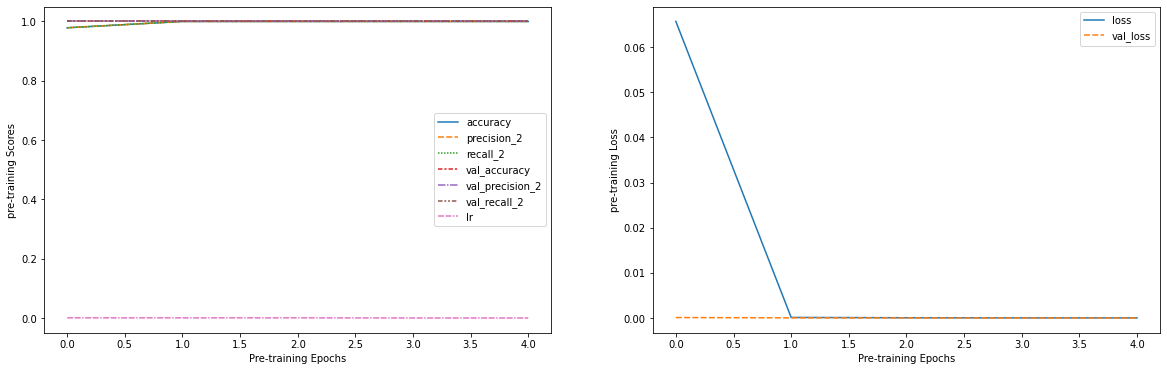

run_id:  2022-05-03_21_48_54.035206_b9db0a42cafc11ecb136ac8247733f47


In [10]:

ptmodel, _, _ = oset.train_ptmodel(bglog=mlog, train_data=train_data, val_data=val_data, test_data=test_data)

In [35]:
ptmodel.summary()

Model: "log_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 log_line_encoder_2 (LogLine  multiple                 36918     
 Encoder)                                                        
                                                                 
 log_seq_encoder_2 (LogSeqEn  multiple                 38096     
 coder)                                                          
                                                                 
 dense_5 (Dense)             multiple                  34        
                                                                 
Total params: 75,048
Trainable params: 75,048
Non-trainable params: 0
_________________________________________________________________


In [64]:
test_batch = next(iter(test_data))
seq_batch, label_batch = test_batch
print('prediction:  ', ptmodel.predict(seq_batch).argmax(axis=-1))
print('actual label:', tf.math.argmax(label_batch, axis=1).numpy())
t_preds, t_label = [], []
for batch in test_data:
    logseq_batch, label_batch = batch
    t_preds.append(ptmodel.predict(seq_batch).argmax(axis=-1))
    t_label.append(tf.math.argmax(label_batch, axis=1).numpy())
fpreds = list(np.array(t_preds).reshape(576))
flabels = list(np.array(t_label).reshape(576))
cm = confusion_matrix(fpreds, flabels)
cls_report = m.classification_report(fpreds, flabels)
print('confusion matrix:\n',cm)
print('classification report:\n', cls_report)

prediction:   [1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0]
actual label: [2 0 2 1 1 2 1 0 0 0 1 2 1 0 0 0 0 1 2 2 0 1 0 0 1 0 0 1 2 1 1 0]
confusion matrix:
 [[ 86  77  89]
 [106 114 104]
 [  0   0   0]]
classification report:
               precision    recall  f1-score   support

           0       0.45      0.34      0.39       252
           1       0.60      0.35      0.44       324
           2       0.00      0.00      0.00         0

    accuracy                           0.35       576
   macro avg       0.35      0.23      0.28       576
weighted avg       0.53      0.35      0.42       576



[[ 77  61  78]
 [118 129 113]
 [  0   0   0]]
              precision    recall  f1-score   support

           0       0.39      0.36      0.37       216
           1       0.68      0.36      0.47       360
           2       0.00      0.00      0.00         0

    accuracy                           0.36       576
   macro avg       0.36      0.24      0.28       576
weighted avg       0.57      0.36      0.43       576



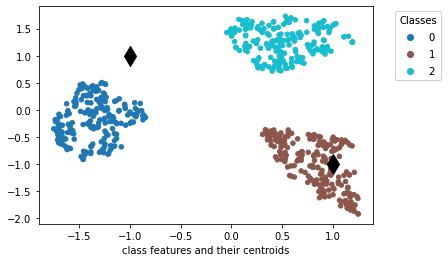

In [39]:
oset.plot_centroids(use_labels=oset.total_preds, centroid_black=True, tsne_perplexity=17)

perpexity : 13


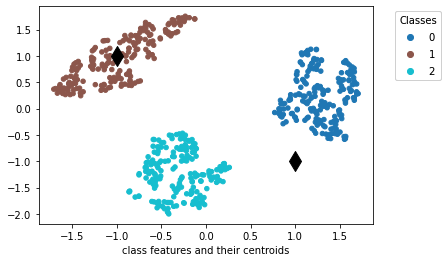

perpexity : 17


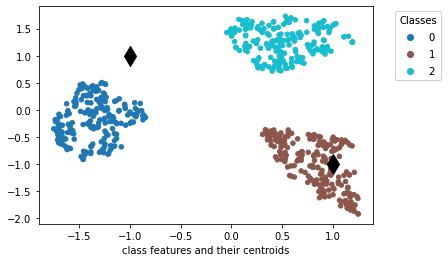

perpexity : 30


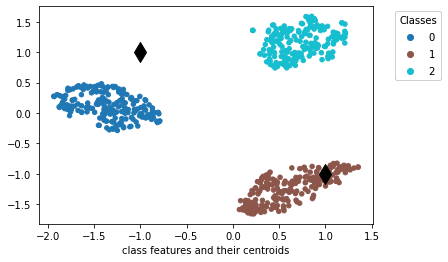

perpexity : 40


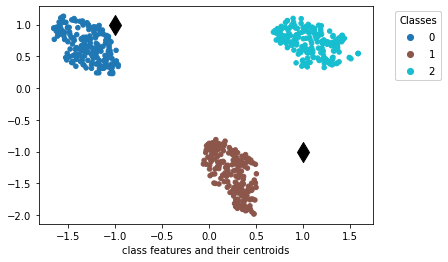

perpexity : 45


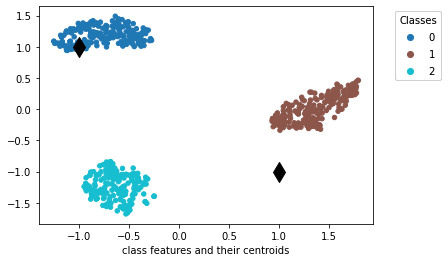

perpexity : 86


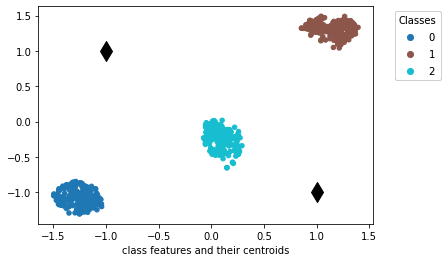

In [38]:
for i in (13, 17, 30, 40, 45, 86):
    print('perpexity :', i)    
    oset.plot_centroids(use_labels=oset.total_preds, centroid_black=True, tsne_perplexity=i)